In [ ]:
# !pip install -q langchain_community
# !pip install langchain faiss-cpu transformers
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
from sentence_transformers import SentenceTransformer
import json
import random
import umap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import time

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

# RAG

## Embeddings

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CustomCodeBERTEmbeddings(Embeddings):
    def __init__(self, model_name="microsoft/codebert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    def embed_documents(self, texts, batch_size=64):  # הוספנו batch_size כארגומנט
        embeddings = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Creating Embeddings"):
            batch = texts[i:i + batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = self.model(**inputs)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # שימוש ב-CLS Token
            embeddings.extend(batch_embeddings)

        return np.array(embeddings)

    def embed_query(self, query):
        return self.embed_documents([query])[0]

# יצירת אובייקט מותאם אישית
embeddings = CustomCodeBERTEmbeddings()


In [ ]:

all_vectors, vector_to_repo = [], {}
current_index = 0
batch_size = 64  # את יכולה להגדיל את ה-batch_size בהתאם לכרטיס המסך שלך

# הכנת רשימות שמכילות את כל ה-Tokens מתוך ה-DataFrame
all_tokens, index_mapping = [], []
for index, topic in tqdm(enumerate(clean_df["Topics"]), total=len(clean_df), desc="Extracting Tokens"):
    if not(isinstance(topic, str) and len(topic.strip()) > 0): continue
    tokens = [token.strip() for token in topic.split(",") if token.strip()]
    all_tokens.extend(tokens)
    index_mapping.extend([index] * len(tokens))

# יצירת האימבדינגס בצורה יעילה עם Batching
all_vectors = embeddings.embed_documents(all_tokens, batch_size=batch_size)

# שמירת המידע במילון כדי שנוכל לחזור למיקום המקורי בדאטה
for i, vector in enumerate(all_vectors):
    vector_to_repo[i] = index_mapping[i]

# המרת הוקטורים למערך NumPy
all_vectors = np.array(all_vectors, dtype='float32')


Creating Embeddings: 100%|██████████| 1641/1641 [00:17<00:00, 93.20it/s]


## IndexFlatIP

In [ ]:

def create_optimized_faiss_indexes(all_vectors, nlist_values):
    """
    יצירת אינדקסים שונים עם FAISS עבור ערכי nlist שונים.
    """
    d = all_vectors.shape[1]
    indexes = {}

    for nlist in nlist_values:
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

        index.train(all_vectors)
        index.add(all_vectors)

        indexes[nlist] = index
        # print(f"\n Created FAISS index with nlist={nlist}. Number of embeddings indexed: {index.ntotal}")

    return indexes

# ---- בניית אינדקסים עם ערכי nlist שונים ----
nlist_values = [100, 200, 300, 500]
indexes = create_optimized_faiss_indexes(all_vectors, nlist_values)


In [ ]:
def search_in_index(query: str, index, top_k: int = 10, nprobe: int = 10):
    """
    חיפוש מתקדם עם FAISS בעזרת IndexIVFFlat.
    """
    index.nprobe = nprobe
    query_vector = embeddings.embed_query(query)

    start_time = time.time()  # מדידת זמן ריצה
    distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)
    end_time = time.time()

    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1:
            continue

        repo_index = vector_to_repo[idx]
        repo_name = clean_df.iloc[repo_index]["Name"]
        repo_url = clean_df.iloc[repo_index]["URL"]
        repo_topics = clean_df.iloc[repo_index]["Topics"]
        score = distances[0][i]

        results.append({
            "name": repo_name,
            "url": repo_url,
            "topics": repo_topics,
            "score": score
        })

    search_time = end_time - start_time  # זמן חיפוש
    return results, search_time


In [ ]:
def grid_search_faiss(queries, indexes, nprobe_values, top_k=10):
    """
    ביצוע חיפוש עבור כל השילובים של nlist ו-nprobe, ושמירת הביצועים והפרויקטים שנמצאו.
    """
    results_summary = []

    for nlist, index in indexes.items():
        for nprobe in nprobe_values:
            for query in queries:
                search_results, search_time = search_in_index(query, index, top_k=top_k, nprobe=nprobe)

                # שמירת שמות הפרויקטים שנמצאו ברשימה
                found_projects = [result['name'] for result in search_results]
                found_topics = [result['topics'] for result in search_results]
                found_urls = [result['url'] for result in search_results]
                found_scores = [result['score'] for result in search_results]

                # שמירת המידע בתוצאות הסופיות
                results_summary.append({
                    "query": query,
                    "nlist": nlist,
                    "nprobe": nprobe,
                    "top_k": top_k,
                    "search_time": search_time,
                    "relevant_results": len(found_projects),
                    "found_projects": found_projects,
                    "found_topics": found_topics,
                    "found_urls": found_urls,
                    "found_scores": found_scores

                })

    # המרת כל התוצאות ל-DataFrame של Pandas
    results_df = pd.DataFrame(results_summary)
    return results_df


In [ ]:
queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]
nprobe_values = [10, 20, 30, 50]

# הפעלת ה-Grid Search המשופר
results_df = grid_search_faiss(queries, indexes, nprobe_values, top_k=10)




Creating Embeddings: 100%|██████████| 1/1 [00:00<00:00, 110.34it/s]


In [ ]:
results_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
query,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing
nlist,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
nprobe,10,10,10,10,10,20,20,20,20,20,30,30,30,30,30,50,50,50,50,50
top_k,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
search_time,0.006078,0.005427,0.005567,0.00653,0.004796,0.009905,0.009791,0.010953,0.009763,0.009616,0.012609,0.0137,0.014086,0.015184,0.012686,0.01974,0.019657,0.020908,0.020957,0.019118
relevant_results,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
found_projects,"[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[student-management-using-django, json-sempai,...","[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[DocTr, hlb-CIFAR10, beartype, alfred-stackexc...","[DocTr, beartype, alfred-stackexchange, nsot, ...","[student-management-using-django, json-sempai,...","[json-sempai, python-vpn, unsupervised-depth-c...","[DeepAFx-ST, nsot, pwncat, penelope, madbg, dj...","[DocTr, how-to-exploit-a-double-free, Scweet, ...","[DocTr, Hitrava, how_attentive_are_gats, impyu...","[student-management-using-django, json-sempai,...","[Hitrava, how_attentive_are_gats, json-sempai,...","[json-sempai, QQzone_crawler, QQZoneMood, pyth...","[DocTr, how-to-exploit-a-double-free, Scweet, ...","[DocTr, Hitrava, how_attentive_are_gats, impyu...","[pivotnacci, PyShell, home_assistant_solarman,...","[video-to-ascii, pip-upgrader, pip-licenses, P...","[Hitrava, ahkab, SpiceyPy, PySpice, how_attent...","[DocTr, pip-upgrader, pip-licenses, PyTorch-Mo..."
found_topics,"[django, django rest framework, ip address, ip...","[attendance, django, hod, staff, student infor...","[django, django rest framework, ip address, ip...","[django, django rest framework, ip address, ip...","[document image processing, document image rec...","[document image processing, document image rec...","[attendance, django, hod, staff, student infor...","[don t, stupid, this, use, esp, ike, ikev1, ik...","[adaptive presets, afx, ai, audio, audio proce...","[document image processing, document image rec...","[document image processing, document image rec...","[attendance, django, hod, staff, student infor...","[band, fitness, gps, gt, health, honor, huawei...","[don t, stupid, this, use, , qqzone, docker, f...","[document image processing, document image rec...","[document image processing, document image rec...","[aspx, jsp, lateral movement, php, socks, aspx...","[ansi colors, ascii, ascii art, bash, cli, con...","[band, fitness, gps, gt, health, honor, huawei...","[document image processing, document image rec..."
found_urls,"[https://github.com/dropbox/nsot, https://gith...",[https://github.com/jobic10/student-management...,"[https://github.com/dropbox/nsot, https://gith...","[https://github.com/dropbox/nsot, https://gith...","[https://github.com/fh2019ustc/DocTr, https://...","[https://github.com/fh2019ustc/DocTr, https://...",[https://github.com/jobic10/student-management...,"[https://github.com/kragniz/json-sempai, https...","[https://github.com/adobe-research/DeepAFx-ST,...","[https://github.com/fh2019ustc/DocTr, https://...","[https://github.com/fh2019ustc/DocTr, https://...",[https://github.com/jobic10/student-management...,"[https://github.com/CTHRU/Hitrava, https://git...","[https://github.com/kragniz/json-sempai, https...","[https://github.com/fh2019ustc/DocTr, https://...","[https://github.com/fh2019ustc/DocTr, https://...","[https://github.com/blackarrowsec/pivotnacci, ...",[https://github.com/joelibaceta/video-to-ascii...,"[https://github.com/CTHRU/Hitrava, https://git.

In [ ]:
# from google.colab import userdata
# from langchain_openai import OpenAI
# import os
# os.environ["OPENAI_API_KEY"] = userdata.get('open_ai_key')

# llm = OpenAI(temperature=0)

In [ ]:


# # פונקציה ליצירת תשובה משודרגת על בסיס התוצאות שנמצאו
# def generate_answer(query: str, top_k: int = 5):
#     # חיפוש באינדקס
#     search_results = search_in_index(query, top_k)

#     # אם אין תוצאות
#     if not search_results:
#         return "No relevant repositories found."

#     # בניית ה-Prompt למודל LLM
#     prompt = f"Answer the question based on the following repositories:\n\nQuery: {query}\n\n"
#     for repo_name, repo_url, repo_topics, score in search_results:
#         prompt += f"Repository: {repo_name}\nTopics: {repo_topics}\nURL: {repo_url}\nScore: {score}\n\n"

#     # שימוש במודל LLM ליצירת תשובה משודרגת
#     response = llm(prompt)
#     return response


In [ ]:
# query = "best practices for deep learning models"
# answer = generate_answer(query)
# print(answer)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


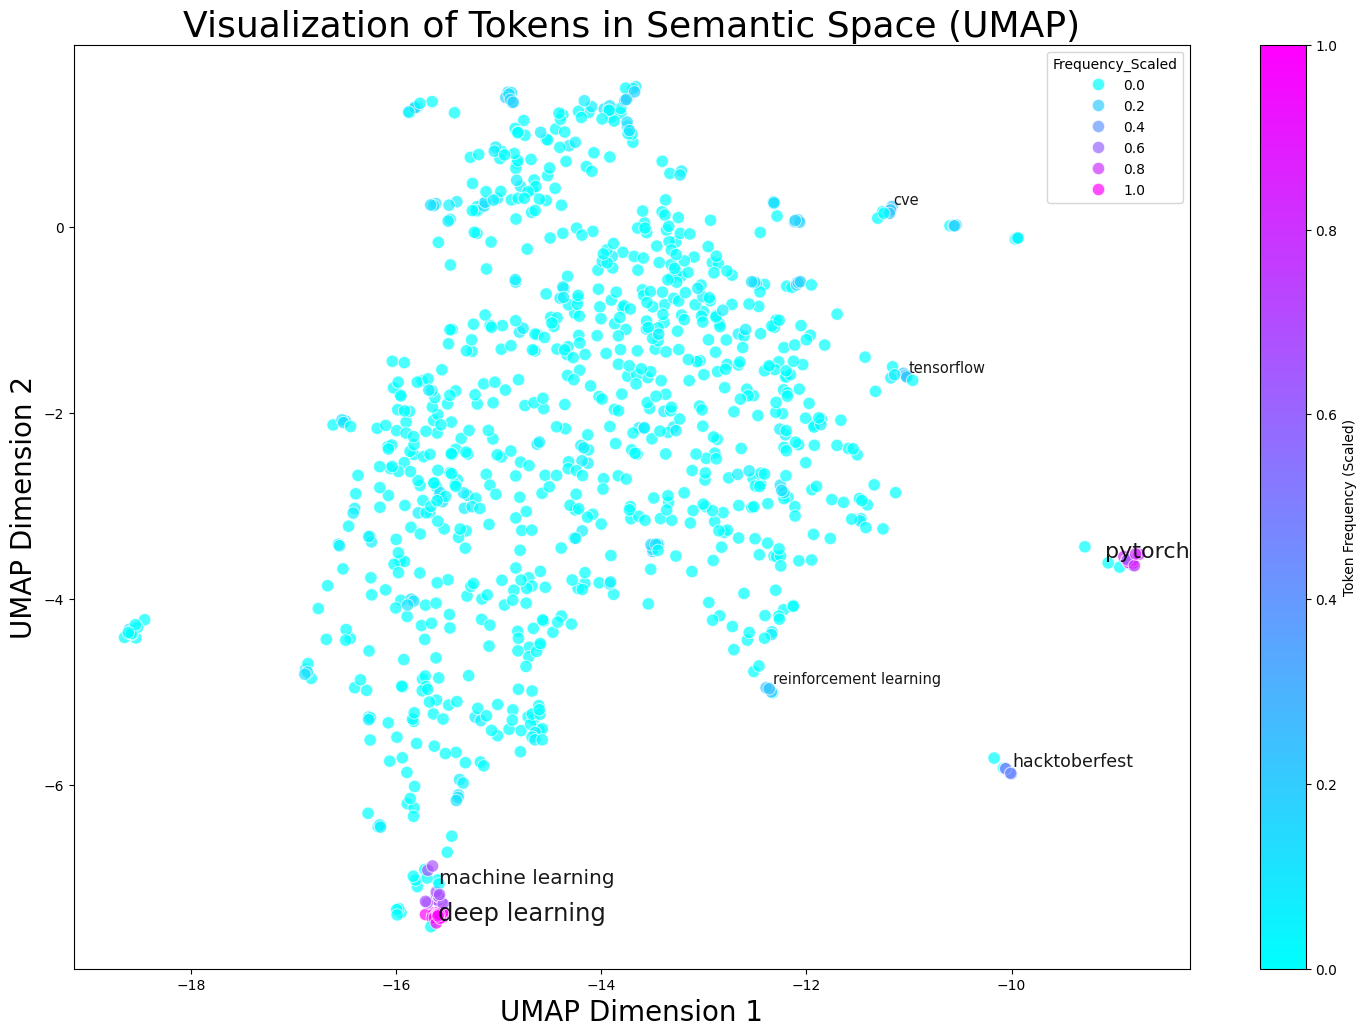

In [ ]:

  # ---- 1. דגימה של תתי-וקטורים ----
  sample_size = 1000
  sample_indices = random.sample(range(len(all_vectors)), min(sample_size, len(all_vectors)))
  sampled_vectors = [all_vectors[i] for i in sample_indices]
  sampled_tokens = [all_tokens[i] for i in sample_indices]

  # ---- 2. הפחתת ממדים בעזרת UMAP ----
  umap_reducer = umap.UMAP(n_neighbors=30, n_components=2, metric='cosine', random_state=42, min_dist=0.1)
  reduced_embeddings = umap_reducer.fit_transform(sampled_vectors)

  # ---- 3. הכנת הנתונים להצגה ----
  embedding_df = pd.DataFrame({
      'UMAP1': reduced_embeddings[:, 0],
      'UMAP2': reduced_embeddings[:, 1],
      'Token': sampled_tokens
  })

  # ---- 4. חישוב תדירות מילות מפתח ----
  token_frequency = embedding_df['Token'].value_counts()
  embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

  # ---- 5. סינון מונחים לפי שכיחותם ----
  threshold_frequency = 5  # הצגת מונחים שמופיעים לפחות מספר פעמים זה
  filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

  # ---- 6. נירמול התדירות בין 0 ל-1 ----
  scaler = MinMaxScaler()
  embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

  # ---- 7. הגדרות גרף ----
  plt.figure(figsize=(18, 12))  # גודל גרף מותאם

  # הגדרת הגרף עם ax
  ax = sns.scatterplot(
      x='UMAP1',
      y='UMAP2',
      hue='Frequency_Scaled',
      palette='cool',
      data=embedding_df,
      s=80,
      alpha=0.7
  )

  # הצגת מפת צבעים
  norm = plt.Normalize(embedding_df['Frequency_Scaled'].min(), embedding_df['Frequency_Scaled'].max())
  sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
  sm.set_array([])
  plt.colorbar(sm, ax=ax, label='Token Frequency (Scaled)', orientation='vertical')

  # ---- 8. הוספת שמות המילים ----
  previous_tokens = set()  # רשימה לשמירה על המילים שכבר הוצגו
  texts = []  # רשימה של הטקסטים שמוסיפים לגרף
  for i, row in filtered_df.iterrows():
      x, y = row['UMAP1'], row['UMAP2']
      token = row['Token']

      # אם המילה לא הופיעה לפני כן, הוסף לגרף
      if token not in previous_tokens:
          texts.append(plt.text(
              x,
              y,
              token,
              fontsize=min(20, 8 + row['Frequency'] / 2),
              alpha=0.9,
              weight='bold' if row['Frequency'] > 50 else 'normal'
          ))
          previous_tokens.add(token)

  # התאמת המילים מבלי לחפוף אחת על השנייה
  adjust_text(texts)

  plt.title('Visualization of Tokens in Semantic Space (UMAP)', fontsize=26)
  plt.xlabel('UMAP Dimension 1', fontsize=20)
  plt.ylabel('UMAP Dimension 2', fontsize=20)
  plt.show()


## Results Analysis with Precision, Recall, and F1 Score

In [ ]:
clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)